# VibeMatch GNN Training Notebook

This notebook trains a LightGCN model on music listening data and generates precomputed embeddings for tracks and artists.

## Datasets Used:
- **Spotify Million Playlist Dataset (MPD)**: 1M playlists, 2M+ tracks
- **Last.fm LFM-360K**: 360K users, listening history

## Output:
- `model/lightgcn_mpd_lfm.pt`: Trained model weights
- `model/precomputed_embeddings.pkl`: Track and artist embeddings
- `model/track_artist_mapping.pkl`: Name → ID mappings

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import LGConv
from torch_geometric.data import Data
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from tqdm import tqdm
import json
import requests
from collections import defaultdict

## 1. Download and Load Datasets

In [6]:
# Cell: Load FMA Dataset (reemplaza la celda de load datasets)

def load_fma_dataset(data_dir="data/fma_metadata"):
    """Load FMA (Free Music Archive) dataset"""
    import ast
    
    # Load tracks with multi-level header
    tracks = pd.read_csv(
        f"{data_dir}/tracks.csv",
        index_col=0,
        header=[0, 1]
    )
    
    # Load genres
    genres = pd.read_csv(f"{data_dir}/genres.csv", index_col=0)
    
    print(f"Loaded {len(tracks)} tracks")
    print(f"Loaded {len(genres)} genres")
    
    # Extract relevant columns
    # FMA has multi-level columns: (category, field)
    track_data = []
    
    for track_id in tqdm(tracks.index, desc="Processing FMA tracks"):
        try:
            title = tracks.loc[track_id, ('track', 'title')]
            artist_name = tracks.loc[track_id, ('artist', 'name')]
            genre_ids = tracks.loc[track_id, ('track', 'genres')]
            
            # Skip if missing essential data
            if pd.isna(artist_name) or pd.isna(title):
                continue
            
            # Parse genre_ids (stored as string representation of list)
            if isinstance(genre_ids, str) and genre_ids != '[]':
                try:
                    genre_list = ast.literal_eval(genre_ids)
                except:
                    genre_list = []
            else:
                genre_list = []
            
            track_data.append({
                'track_id': track_id,
                'track_name': str(title),
                'artist_name': str(artist_name),
                'genre_ids': genre_list
            })
        except Exception as e:
            continue
    
    print(f"Processed {len(track_data)} valid tracks")
    return track_data, genres

## 2. Build Heterogeneous Graph

Graph structure:
- Nodes: Tracks + Artists
- Edges: 
  - Track → Artist (authorship)
  - Track → Track (co-occurrence in playlists)
  - Artist → Artist (collaboration/similarity)

In [7]:
# Cell: Updated MusicGraphBuilder for FMA

class MusicGraphBuilder:
    def __init__(self):
        self.track_to_id = {}
        self.artist_to_id = {}
        self.genre_to_id = {}
        self.edges = defaultdict(list)
        self.track_names = {}  # track_id -> name for lookup
        
    def add_fma_data(self, track_data, genres_df):
        """Add FMA dataset to graph"""
        # Build genre mapping
        for genre_id in genres_df.index:
            if genre_id not in self.genre_to_id:
                self.genre_to_id[genre_id] = len(self.genre_to_id)
        
        # Group tracks by artist for co-occurrence
        artist_tracks = defaultdict(list)
        
        for track in tqdm(track_data, desc="Building graph"):
            track_id = track['track_id']
            artist_name = track['artist_name']
            track_name = track['track_name']
            genre_ids = track['genre_ids']
            
            # Add track node
            if track_id not in self.track_to_id:
                self.track_to_id[track_id] = len(self.track_to_id)
                self.track_names[track_id] = track_name
            
            # Add artist node
            if artist_name not in self.artist_to_id:
                self.artist_to_id[artist_name] = len(self.artist_to_id)
            
            node_track_id = self.track_to_id[track_id]
            node_artist_id = self.artist_to_id[artist_name]
            
            # Track → Artist edge
            self.edges['track_to_artist'].append((node_track_id, node_artist_id))
            
            # Track artist's tracks for co-occurrence
            artist_tracks[artist_name].append(node_track_id)
            
            # Track → Genre edges (for richer graph)
            for genre_id in genre_ids:
                if genre_id in self.genre_to_id:
                    self.edges['track_to_genre'].append((node_track_id, self.genre_to_id[genre_id]))
        
        # Create Track → Track edges (same artist = similar)
        print("Creating track-track edges...")
        for artist, tracks in tqdm(artist_tracks.items()):
            for i, t1 in enumerate(tracks):
                for t2 in tracks[i+1:i+5]:  # Limit connections per track
                    self.edges['track_to_track'].append((t1, t2))
        
        print(f"Graph: {len(self.track_to_id)} tracks, {len(self.artist_to_id)} artists, {len(self.genre_to_id)} genres")
    
    def build_pyg_data(self, embedding_dim=128):
        """Build PyTorch Geometric Data object"""
        num_tracks = len(self.track_to_id)
        num_artists = len(self.artist_to_id)
        num_genres = len(self.genre_to_id)
        total_nodes = num_tracks + num_artists + num_genres
        
        print(f"Total nodes: {total_nodes}")
        
        # Initialize node features
        x = torch.randn(total_nodes, embedding_dim)
        
        # Build edge index
        edge_list = []
        
        # Track-Artist edges (bidirectional)
        for track_id, artist_id in self.edges['track_to_artist']:
            artist_node = num_tracks + artist_id
            edge_list.append([track_id, artist_node])
            edge_list.append([artist_node, track_id])
        
        # Track-Track edges (bidirectional)
        for t1, t2 in self.edges['track_to_track']:
            edge_list.append([t1, t2])
            edge_list.append([t2, t1])
        
        # Track-Genre edges (bidirectional)
        for track_id, genre_id in self.edges['track_to_genre']:
            genre_node = num_tracks + num_artists + genre_id
            edge_list.append([track_id, genre_node])
            edge_list.append([genre_node, track_id])
        
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        
        print(f"Total edges: {edge_index.size(1)}")
        
        data = Data(x=x, edge_index=edge_index)
        
        return data, num_tracks, num_artists, num_genres

In [8]:
# Cell: Build graph with FMA data (reemplaza la celda de synthetic data)

print("Loading FMA dataset...")
track_data, genres_df = load_fma_dataset("data/fma_metadata")

print("\nBuilding music graph...")
graph_builder = MusicGraphBuilder()
graph_builder.add_fma_data(track_data, genres_df)

data, num_tracks, num_artists, num_genres = graph_builder.build_pyg_data(embedding_dim=128)
print(f"\nGraph ready: {data.num_nodes} nodes, {data.edge_index.size(1)} edges")

Loading FMA dataset...
Loaded 106574 tracks
Loaded 163 genres


Processing FMA tracks: 100%|██████████| 106574/106574 [00:39<00:00, 2687.45it/s]


Processed 106573 valid tracks

Building music graph...


Building graph: 100%|██████████| 106573/106573 [00:00<00:00, 443625.35it/s]


Creating track-track edges...


100%|██████████| 16294/16294 [00:00<00:00, 203141.22it/s]


Graph: 106573 tracks, 16294 artists, 163 genres
Total nodes: 123030
Total edges: 1352316

Graph ready: 123030 nodes, 1352316 edges


## 3. Define LightGCN Model

In [9]:
class LightGCN(torch.nn.Module):
    """LightGCN for music recommendation"""
    
    def __init__(self, num_nodes, embedding_dim=128, num_layers=3):
        super().__init__()
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        
        # Learnable embeddings
        self.embedding = torch.nn.Embedding(num_nodes, embedding_dim)
        
        # LightGCN layers
        self.convs = torch.nn.ModuleList([
            LGConv() for _ in range(num_layers)
        ])
        
        self.reset_parameters()
    
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight)
    
    def forward(self, edge_index):
        x = self.embedding.weight
        
        # Layer-wise propagation
        embeddings = [x]
        for conv in self.convs:
            x = conv(x, edge_index)
            embeddings.append(x)
        
        # Average all layers
        final_embedding = torch.mean(torch.stack(embeddings), dim=0)
        
        return final_embedding

## 4. Train Model

In [32]:
# Training configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = LightGCN(
    num_nodes=data.num_nodes,
    embedding_dim=128,
    num_layers=3
).to(device)

data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [33]:
def train_epoch(model, data, optimizer, num_samples=10000, reg_weight=1e-5):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    embeddings = model(data.edge_index)
    
    # Sample positive edges
    perm = torch.randperm(data.edge_index.size(1), device=device)[:num_samples]
    pos_edges = data.edge_index[:, perm]
    
    # Positive scores
    pos_scores = (embeddings[pos_edges[0]] * embeddings[pos_edges[1]]).sum(dim=1)
    
    # Hard negative sampling: sample more negatives and pick hardest
    num_neg_candidates = num_samples * 5
    neg_candidates = torch.randint(0, data.num_nodes, (2, num_neg_candidates), device=device)
    neg_scores_all = (embeddings[neg_candidates[0]] * embeddings[neg_candidates[1]]).sum(dim=1)
    
    # Select top-k hardest negatives (highest scores)
    _, hard_neg_idx = torch.topk(neg_scores_all, num_samples)
    neg_scores = neg_scores_all[hard_neg_idx]
    
    # BPR loss with margin
    margin = 0.5
    loss = torch.clamp(margin - pos_scores + neg_scores, min=0).mean()
    
    # L2 regularization on embeddings (prevents overfitting)
    reg_loss = reg_weight * (embeddings ** 2).mean()
    
    total_loss = loss + reg_loss
    
    total_loss.backward()
    optimizer.step()
    
    return loss.item(), reg_loss.item()

In [34]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Training configuration
num_epochs = 500
patience = 20
best_loss = float('inf')
patience_counter = 0

# Scheduler: reduce LR when loss plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

loss_history = []

for epoch in tqdm(range(num_epochs)):
    loss, reg_loss = train_epoch(model, data, optimizer, num_samples=15000, reg_weight=1e-5)
    loss_history.append(loss)
    
    # Update scheduler
    scheduler.step(loss)
    
    # Early stopping check
    if loss < best_loss - 0.001:  # Minimum improvement threshold
        best_loss = loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), "model/lightgcn_best.pt")
    else:
        patience_counter += 1
    
    if (epoch + 1) % 20 == 0:
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Reg: {reg_loss:.6f}, LR: {lr:.6f}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(torch.load("model/lightgcn_best.pt"))
print(f"\nBest loss: {best_loss:.4f}")

  4%|▍         | 20/500 [00:05<02:32,  3.16it/s]

Epoch 20/500, Loss: 0.4179, Reg: 0.000000, LR: 0.001000


  8%|▊         | 41/500 [00:11<01:56,  3.95it/s]

Epoch 40/500, Loss: 0.3165, Reg: 0.000000, LR: 0.001000


 12%|█▏        | 60/500 [00:15<01:14,  5.88it/s]

Epoch 60/500, Loss: 0.3003, Reg: 0.000000, LR: 0.001000


 16%|█▌        | 81/500 [00:19<01:19,  5.26it/s]

Epoch 80/500, Loss: 0.2816, Reg: 0.000000, LR: 0.001000


 20%|██        | 101/500 [00:23<01:12,  5.51it/s]

Epoch 100/500, Loss: 0.2666, Reg: 0.000000, LR: 0.001000


 24%|██▍       | 121/500 [00:27<01:14,  5.06it/s]

Epoch 120/500, Loss: 0.2433, Reg: 0.000000, LR: 0.001000


 28%|██▊       | 141/500 [00:31<01:13,  4.87it/s]

Epoch 140/500, Loss: 0.2211, Reg: 0.000000, LR: 0.001000


 32%|███▏      | 161/500 [00:36<01:01,  5.48it/s]

Epoch 160/500, Loss: 0.2012, Reg: 0.000000, LR: 0.001000


 36%|███▌      | 180/500 [00:40<01:06,  4.82it/s]

Epoch 180/500, Loss: 0.1769, Reg: 0.000000, LR: 0.001000


 40%|████      | 201/500 [00:46<00:49,  6.06it/s]

Epoch 200/500, Loss: 0.1564, Reg: 0.000000, LR: 0.001000


 44%|████▍     | 221/500 [00:50<00:53,  5.23it/s]

Epoch 220/500, Loss: 0.1357, Reg: 0.000000, LR: 0.001000


 48%|████▊     | 241/500 [00:54<00:40,  6.34it/s]

Epoch 240/500, Loss: 0.1171, Reg: 0.000000, LR: 0.001000


 52%|█████▏    | 260/500 [00:58<00:42,  5.61it/s]

Epoch 260/500, Loss: 0.1002, Reg: 0.000000, LR: 0.001000


 56%|█████▌    | 281/500 [01:02<00:37,  5.76it/s]

Epoch 280/500, Loss: 0.0860, Reg: 0.000000, LR: 0.001000


 60%|██████    | 301/500 [01:05<00:26,  7.51it/s]

Epoch 300/500, Loss: 0.0751, Reg: 0.000000, LR: 0.001000


 64%|██████▍   | 321/500 [01:09<00:32,  5.52it/s]

Epoch 320/500, Loss: 0.0629, Reg: 0.000000, LR: 0.001000


 68%|██████▊   | 341/500 [01:12<00:23,  6.82it/s]

Epoch 340/500, Loss: 0.0587, Reg: 0.000000, LR: 0.001000


 72%|███████▏  | 361/500 [01:16<00:19,  7.17it/s]

Epoch 360/500, Loss: 0.0497, Reg: 0.000000, LR: 0.001000


 76%|███████▌  | 380/500 [01:18<00:18,  6.64it/s]

Epoch 380/500, Loss: 0.0448, Reg: 0.000000, LR: 0.001000


 80%|████████  | 401/500 [01:24<00:11,  8.34it/s]

Epoch 400/500, Loss: 0.0390, Reg: 0.000000, LR: 0.001000


 84%|████████▍ | 421/500 [01:26<00:09,  8.30it/s]

Epoch 420/500, Loss: 0.0364, Reg: 0.000000, LR: 0.001000


 88%|████████▊ | 441/500 [01:29<00:07,  7.76it/s]

Epoch 440/500, Loss: 0.0320, Reg: 0.000000, LR: 0.001000


 92%|█████████▏| 461/500 [01:32<00:04,  8.36it/s]

Epoch 460/500, Loss: 0.0307, Reg: 0.000000, LR: 0.000500


 96%|█████████▌| 481/500 [01:35<00:02,  8.51it/s]

Epoch 480/500, Loss: 0.0286, Reg: 0.000000, LR: 0.000500


 98%|█████████▊| 488/500 [01:36<00:02,  5.08it/s]


Early stopping at epoch 489

Best loss: 0.0276


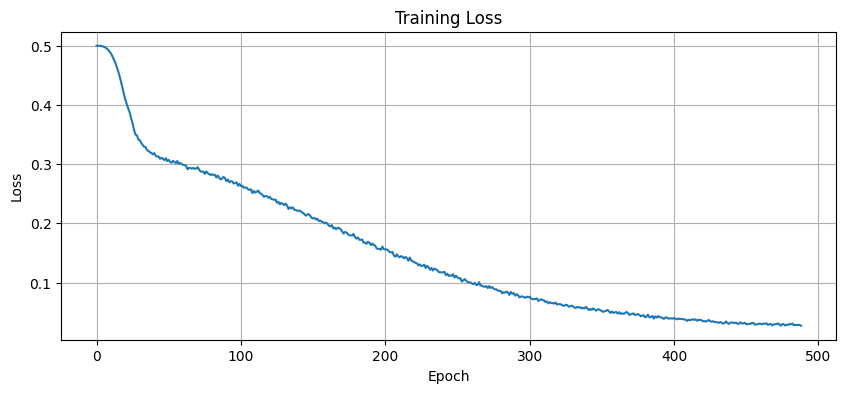

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.savefig('model/training_loss.png')
plt.show()

## 5. Extract and Save Embeddings

In [36]:
# Generate final embeddings
model.eval()
with torch.no_grad():
    final_embeddings = model(data.edge_index).cpu().numpy()

# Split into tracks, artists, and genres correctly
track_embeddings_array = final_embeddings[:num_tracks]
artist_embeddings_array = final_embeddings[num_tracks:num_tracks + num_artists]
genre_embeddings_array = final_embeddings[num_tracks + num_artists:]

print(f"Track embeddings shape: {track_embeddings_array.shape}")
print(f"Artist embeddings shape: {artist_embeddings_array.shape}")
print(f"Genre embeddings shape: {genre_embeddings_array.shape}")

Track embeddings shape: (106573, 128)
Artist embeddings shape: (16294, 128)
Genre embeddings shape: (163, 128)


In [37]:
# Create lookups: name -> embedding
track_embeddings = {}
for track_id, node_id in graph_builder.track_to_id.items():
    # Use track name as key for easier lookup
    track_name = graph_builder.track_names.get(track_id, str(track_id))
    normalized_name = track_name.lower().strip()
    track_embeddings[normalized_name] = track_embeddings_array[node_id]
    # Also store by ID
    track_embeddings[f"fma:{track_id}"] = track_embeddings_array[node_id]

artist_embeddings = {}
for artist_name, artist_id in graph_builder.artist_to_id.items():
    normalized_name = artist_name.lower().strip()
    artist_embeddings[normalized_name] = artist_embeddings_array[artist_id]

print(f"Created {len(track_embeddings)} track embeddings")
print(f"Created {len(artist_embeddings)} artist embeddings")

Created 200081 track embeddings
Created 16290 artist embeddings


In [38]:
# Save model
torch.save(model.state_dict(), "model/lightgcn_mpd_lfm.pt")
print("Saved model to model/lightgcn_mpd_lfm.pt")

# Save embeddings
with open("model/precomputed_embeddings.pkl", "wb") as f:
    pickle.dump({
        "track_embeddings": track_embeddings,
        "artist_embeddings": artist_embeddings
    }, f)
print("Saved embeddings to model/precomputed_embeddings.pkl")

# Save mappings
with open("model/track_artist_mapping.pkl", "wb") as f:
    pickle.dump({
        "track_to_id": graph_builder.track_to_id,
        "artist_to_id": graph_builder.artist_to_id
    }, f)
print("Saved mappings to model/track_artist_mapping.pkl")

Saved model to model/lightgcn_mpd_lfm.pt
Saved embeddings to model/precomputed_embeddings.pkl
Saved mappings to model/track_artist_mapping.pkl


## 6. Verification

In [89]:
# Test similarity
def cosine_similarity(emb1, emb2):
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

# Verificar estadísticas de embeddings
print("=== Embedding Statistics ===")
print(f"Track embeddings: {len(track_embeddings)}")
print(f"Artist embeddings: {len(artist_embeddings)}")
print(f"Embedding dimension: {list(artist_embeddings.values())[0].shape}")

# Calcular distribución de similitudes
import random
sample_artists = random.sample(list(artist_embeddings.keys()), min(100, len(artist_embeddings)))
all_sims = []
for i, a1 in enumerate(sample_artists):
    for a2 in sample_artists[i+1:]:
        sim = cosine_similarity(artist_embeddings[a1], artist_embeddings[a2])
        all_sims.append(sim)

print(f"\n=== Similarity Distribution (sample of {len(all_sims)} pairs) ===")
print(f"Mean: {np.mean(all_sims):.4f}")
print(f"Std: {np.std(all_sims):.4f}")
print(f"Min: {np.min(all_sims):.4f}")
print(f"Max: {np.max(all_sims):.4f}")

# Find similar artists (usando un artista aleatorio)
test_artist = random.choice(list(artist_embeddings.keys()))
test_emb = artist_embeddings[test_artist]

similarities = []
for artist, emb in artist_embeddings.items():
    if artist != test_artist:
        sim = cosine_similarity(test_emb, emb)
        similarities.append((artist, sim))

top_similar = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]
print(f"\n=== Most similar to '{test_artist}' ===")
for artist, sim in top_similar:
    print(f"  {artist}: {sim:.4f}")

=== Embedding Statistics ===
Track embeddings: 200081
Artist embeddings: 16290
Embedding dimension: (128,)

=== Similarity Distribution (sample of 4950 pairs) ===
Mean: 0.1753
Std: 0.2575
Min: -0.4242
Max: 0.9503

=== Most similar to 'madamme cell' ===
  mr. groin: 0.9178
  formicophilia: 0.9151
  trance;gate: 0.9103
  lezet & his nephew vanja: 0.9031
  about.thewindow: 0.8962


## Done!

The model and embeddings are now ready to use in the VibeMatch API.

Next steps:
1. Copy the `model/` directory to your backend
2. The API will load these embeddings automatically
3. Run the ghost user seeding script